In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=2, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.0
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [3]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

train_lables_file = './cifar10/trainLabels.csv'
test_csv_file = './cifar10/sampleSubmission.csv'
train_folder = 'cifar10\\train'
test_folder = 'cifar10\\test'

def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    with open(filepath, 'r') as f:
        lines = f.readlines()[1:]
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))
    return results

train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)

import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[('cifar10\\train\\1.png', 'frog'),
 ('cifar10\\train\\2.png', 'truck'),
 ('cifar10\\train\\3.png', 'truck'),
 ('cifar10\\train\\4.png', 'deer'),
 ('cifar10\\train\\5.png', 'automobile')]
[('cifar10\\test\\1.png', 'cat'),
 ('cifar10\\test\\2.png', 'cat'),
 ('cifar10\\test\\3.png', 'cat'),
 ('cifar10\\test\\4.png', 'cat'),
 ('cifar10\\test\\5.png', 'cat')]
50000 300000


In [4]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

              filepath       class
0  cifar10\train\1.png        frog
1  cifar10\train\2.png       truck
2  cifar10\train\3.png       truck
3  cifar10\train\4.png        deer
4  cifar10\train\5.png  automobile
                  filepath       class
0  cifar10\train\45001.png       horse
1  cifar10\train\45002.png  automobile
2  cifar10\train\45003.png        deer
3  cifar10\train\45004.png  automobile
4  cifar10\train\45005.png    airplane
             filepath class
0  cifar10\test\1.png   cat
1  cifar10\test\2.png   cat
2  cifar10\test\3.png   cat
3  cifar10\test\4.png   cat
4  cifar10\test\5.png   cat


In [5]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse',
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [6]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


In [7]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu', 
                        input_shape=[width, height, channels]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 256)       1

In [8]:
epochs = 10
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_num // batch_size,
                              epochs = epochs,
                              validation_data = valid_generator,
                              validation_steps = valid_num // batch_size)

Epoch 1/10
1406/1406 [==============================] - 720s 512ms/step - loss: 2.3253 - accuracy: 0.3003 - val_loss: 1.7409 - val_accuracy: 0.4018
Epoch 2/10
1406/1406 [==============================] - 88s 63ms/step - loss: 1.5714 - accuracy: 0.4326 - val_loss: 1.5342 - val_accuracy: 0.4744
Epoch 3/10
1406/1406 [==============================] - 89s 63ms/step - loss: 1.3854 - accuracy: 0.5027 - val_loss: 1.2408 - val_accuracy: 0.5775
Epoch 4/10
1406/1406 [==============================] - 89s 63ms/step - loss: 1.2117 - accuracy: 0.5691 - val_loss: 1.1958 - val_accuracy: 0.6030
Epoch 5/10
1406/1406 [==============================] - 89s 63ms/step - loss: 1.0753 - accuracy: 0.6211 - val_loss: 1.0400 - val_accuracy: 0.6556
Epoch 6/10
1406/1406 [==============================] - 89s 63ms/step - loss: 0.9787 - accuracy: 0.6568 - val_loss: 0.9413 - val_accuracy: 0.6957
Epoch 7/10
1406/1406 [==============================] - 89s 63ms/step - loss: 0.8837 - accuracy: 0.6961 - val_loss: 0.8528

In [19]:
print(historyl.sha)

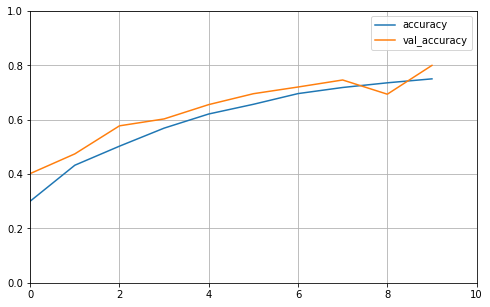

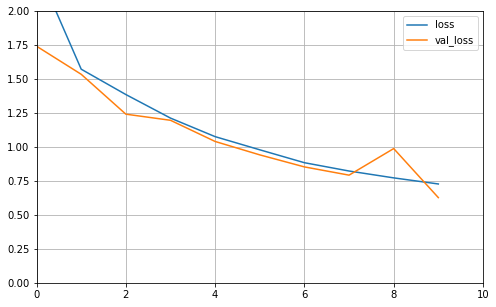

In [9]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)




In [20]:
test_csv_file = './cifar10/sampleSubmission.csv'
test_folder = 'C:\\test'


test_csv_info = parse_csv_file(test_csv_file, test_folder)
import pprint
pprint.pprint(test_csv_info[0:5])
print( len(test_csv_info))

[('C:\\test\\1.png', 'cat'),
 ('C:\\test\\2.png', 'cat'),
 ('C:\\test\\3.png', 'cat'),
 ('C:\\test\\4.png', 'cat'),
 ('C:\\test\\5.png', 'cat')]
300000


In [21]:
test_df = pd.DataFrame(test_csv_info)


test_df.columns = ['filepath', 'class']

print(test_df.head())

        filepath class
0  C:\test\1.png   cat
1  C:\test\2.png   cat
2  C:\test\3.png   cat
3  C:\test\4.png   cat
4  C:\test\5.png   cat


In [22]:


test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [ ]:
# model = keras.models.load_model('.\keras_save_model')

In [23]:
# 并行化,workers 为10个进程或线程，当use_multiprocessing = True 为多进程，，当为False 时为多线程
test_predict = model.predict_generator(test_generator,
                                       workers = 16,
                                       use_multiprocessing = False,
                                       verbose = 1)

9375/9375 [==============================] - 180s 19ms/step


In [24]:
print(test_predict.shape)
print(test_predict[0:5])

(300000, 10)
[[7.18177781e-02 5.79847023e-02 2.24433746e-02 9.69256535e-02
  1.59412146e-01 3.24099101e-02 5.66241220e-02 5.71559183e-02
  2.66243592e-02 4.18602020e-01]
 [9.13135290e-01 1.51833243e-04 9.72151582e-04 4.58677066e-03
  7.76871070e-02 1.17830874e-04 1.47864025e-03 2.11704755e-04
  1.57723413e-03 8.14063751e-05]
 [1.01248988e-04 8.08880448e-01 2.13633399e-07 8.99521069e-07
  3.56900145e-08 8.02241914e-07 9.63237653e-07 4.30766204e-06
  3.44710425e-05 1.90976635e-01]
 [9.24757682e-03 4.78849310e-04 6.45610489e-05 1.10974470e-04
  6.69986184e-05 1.70333424e-05 6.94936243e-05 1.05114224e-04
  9.89455283e-01 3.84004641e-04]
 [8.59199941e-01 5.88854542e-04 6.84809610e-02 4.27513104e-03
  1.88097879e-02 7.90837803e-04 3.57397692e-03 2.26807687e-03
  4.08547036e-02 1.15770637e-03]]


In [25]:
test_predict_class_indices = np.argmax(test_predict, axis = 1)
print(test_predict_class_indices[0:5])
test_predict_class = [class_names[index] 
                      for index in test_predict_class_indices]
print(test_predict_class[0:5])

[9 0 1 8 0]
['truck', 'airplane', 'automobile', 'ship', 'airplane']


In [26]:
def generate_submissions(filename, predict_class):
    with open(filename, 'w') as f:
        f.write('id,label\n')
        for i in range(len(predict_class)):
            f.write('%d,%s\n' % (i+1, predict_class[i]))

output_file = "./cifar10/submission_10_again.csv"
generate_submissions(output_file, test_predict_class)

In [18]:
tf.saved_model.save(model,'keras_save_model_10')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: keras_save_model_10\assets
